<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span><ul class="toc-item"><li><span><a href="#Solution-Summary" data-toc-modified-id="Solution-Summary-1.1">Solution Summary</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.2">Load Data</a></span></li><li><span><a href="#Data-Profile" data-toc-modified-id="Data-Profile-1.3">Data Profile</a></span></li><li><span><a href="#Feature-engineering-and-data-cleaning" data-toc-modified-id="Feature-engineering-and-data-cleaning-1.4">Feature engineering and data cleaning</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-1.5">EDA</a></span><ul class="toc-item"><li><span><a href="#Sale-per-ProductFamily" data-toc-modified-id="Sale-per-ProductFamily-1.5.1">Sale per ProductFamily</a></span></li><li><span><a href="#Sale-by-product" data-toc-modified-id="Sale-by-product-1.5.2">Sale by product</a></span></li></ul></li></ul></li><li><span><a href="#Data-splitting" data-toc-modified-id="Data-splitting-2">Data splitting</a></span></li><li><span><a href="#No-Lagging-Approach" data-toc-modified-id="No-Lagging-Approach-3">No Lagging Approach</a></span><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3.1">Modelling</a></span><ul class="toc-item"><li><span><a href="#Peformance-using-Predicted-Sales-columns" data-toc-modified-id="Peformance-using-Predicted-Sales-columns-3.1.1">Peformance using Predicted Sales columns</a></span></li><li><span><a href="#Peformance-using-Approach-1" data-toc-modified-id="Peformance-using-Approach-1-3.1.2">Peformance using Approach 1</a></span></li></ul></li></ul></li><li><span><a href="#Lagging-approach-(using-previous-day-sale)" data-toc-modified-id="Lagging-approach-(using-previous-day-sale)-4">Lagging approach (using previous day sale)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-preperation" data-toc-modified-id="Data-preperation-4.0.1">Data preperation</a></span></li><li><span><a href="#Data-splitting" data-toc-modified-id="Data-splitting-4.0.2">Data splitting</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4.0.3">Modelling</a></span></li><li><span><a href="#Performance-using-approach-2" data-toc-modified-id="Performance-using-approach-2-4.0.4">Performance using approach 2</a></span></li><li><span><a href="#Performance-using-Predicted-Sale-columns" data-toc-modified-id="Performance-using-Predicted-Sale-columns-4.0.5">Performance using Predicted Sale columns</a></span></li></ul></li><li><span><a href="#Analysing-the-feature-importance-of-the-features" data-toc-modified-id="Analysing-the-feature-importance-of-the-features-4.1">Analysing the feature importance of the features</a></span></li></ul></li></ul></div>

# Objective

1- Profile and describe the data-set and its attributes to your best ability. List any anomalies and patterns.  (Please share any Python code/Graphs used)

2- Create the accuracy rate/measure of the current forecasted results (Please share any Python code/Graphs used)

3- Create an algorithm using Python based on the existing data-set and compare the accuracy of the forecasted sales & actual sales (Please share the Python Code).

4- Explain the accuracy of your predicted model and the evaluation steps involved. (Please share the Python Code).

5- List the next steps on how you can improve the accuracy of your model

## Solution Summary


    Seven days of collected data is provided. The dataset has the following main features: SaleDate	sales_district_text, Predicted Sales, Acutal Sales, Store, Product, ProductFamily. All the features except the (Actual Sale) are categorial features. 

    The solution provided in this notebook, treats the problem as regression problem with (Actual Sale) as the target variable to predict. CatBoost algorithm is used to solve it. Root mean square error and Symmetric mean absolute percetage error are used to evaluate the models.

    Two approaches are suggested. The first approach is to use the given features only as independent variables and to predict the (Actual Sale). The second approach is using lagging (time series), i.e., the (Actual Sale) of the previous day as an independent feature as well. This approach gives more context to the model and in fact has improved the accuracy (32% compared with 39%). The data is siplited into training and testing and the models are evaluated on both. 

    More evaluation could be done. The accuracy of predicting the sale of each product or each store and product family can be easily calculated as wll.

    Different ways could be used to improve the accuracy. The data is limited to seven days which is not enough to capture the sesanality of the sale. Therefore more data is needed. The parameters of the model can be further tunded using Baysian optimisation in SageMaker using containers.



In [16]:
#Basic libraries
import pandas as pd
import numpy as np
import datetime

#Graphic libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#Quick EDA
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#############################################
#         evaluation function               #
#############################################
#Evaluation metrics
from sklearn.metrics import (
                             r2_score,
                             mean_squared_error,
                             mean_absolute_error,
                             make_scorer)
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(2 * (y_true - y_pred) / (y_true + y_pred))) * 100

# PE
def percentage_error(y_true, y_pred):
    return ((y_true - y_pred) / y_true) * 100

# Error
def error(y_true, y_pred):
    return np.abs(y_true - y_pred)

# RMSE
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSPE
def root_mean_square_percent_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

from sklearn.metrics import r2_score

## Load Data

In [17]:
data_df = pd.read_excel('./data/PredictiveTestSet.xlsx', parse_dates=["SaleDate"], index_col='RecordID')

## Data Profile

In [19]:
pandas_profiling.ProfileReport(data_df.reset_index(), check_correlation=True)

Number of variables,9
Number of observations,494095
Total Missing (%),11.1%
Total size in memory,33.9 MiB
Average record size in memory,72.0 B
Numeric,2
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,2


## Feature engineering and data cleaning

In [20]:
#Removing missing values in the 'Predicted Sales'
data_df.dropna(inplace=True, subset=['Predicted Sales'])

#Removing negative values in 'Actual Sale'
data_df = data_df[data_df['Acutal Sales'] >= 0.0]

In [21]:
#Extract day of week and month
data_df['dayofweek'] = data_df.SaleDate.dt.dayofweek
data_df['weekday_name'] = data_df.SaleDate.dt.weekday_name
data_df['month'] = data_df.SaleDate.dt.month

In [22]:
categorial_features = ['weekday_name', 'sales_district_text', 'Store', 'Product', 'ProductFamily']

## EDA

### Sale per ProductFamily

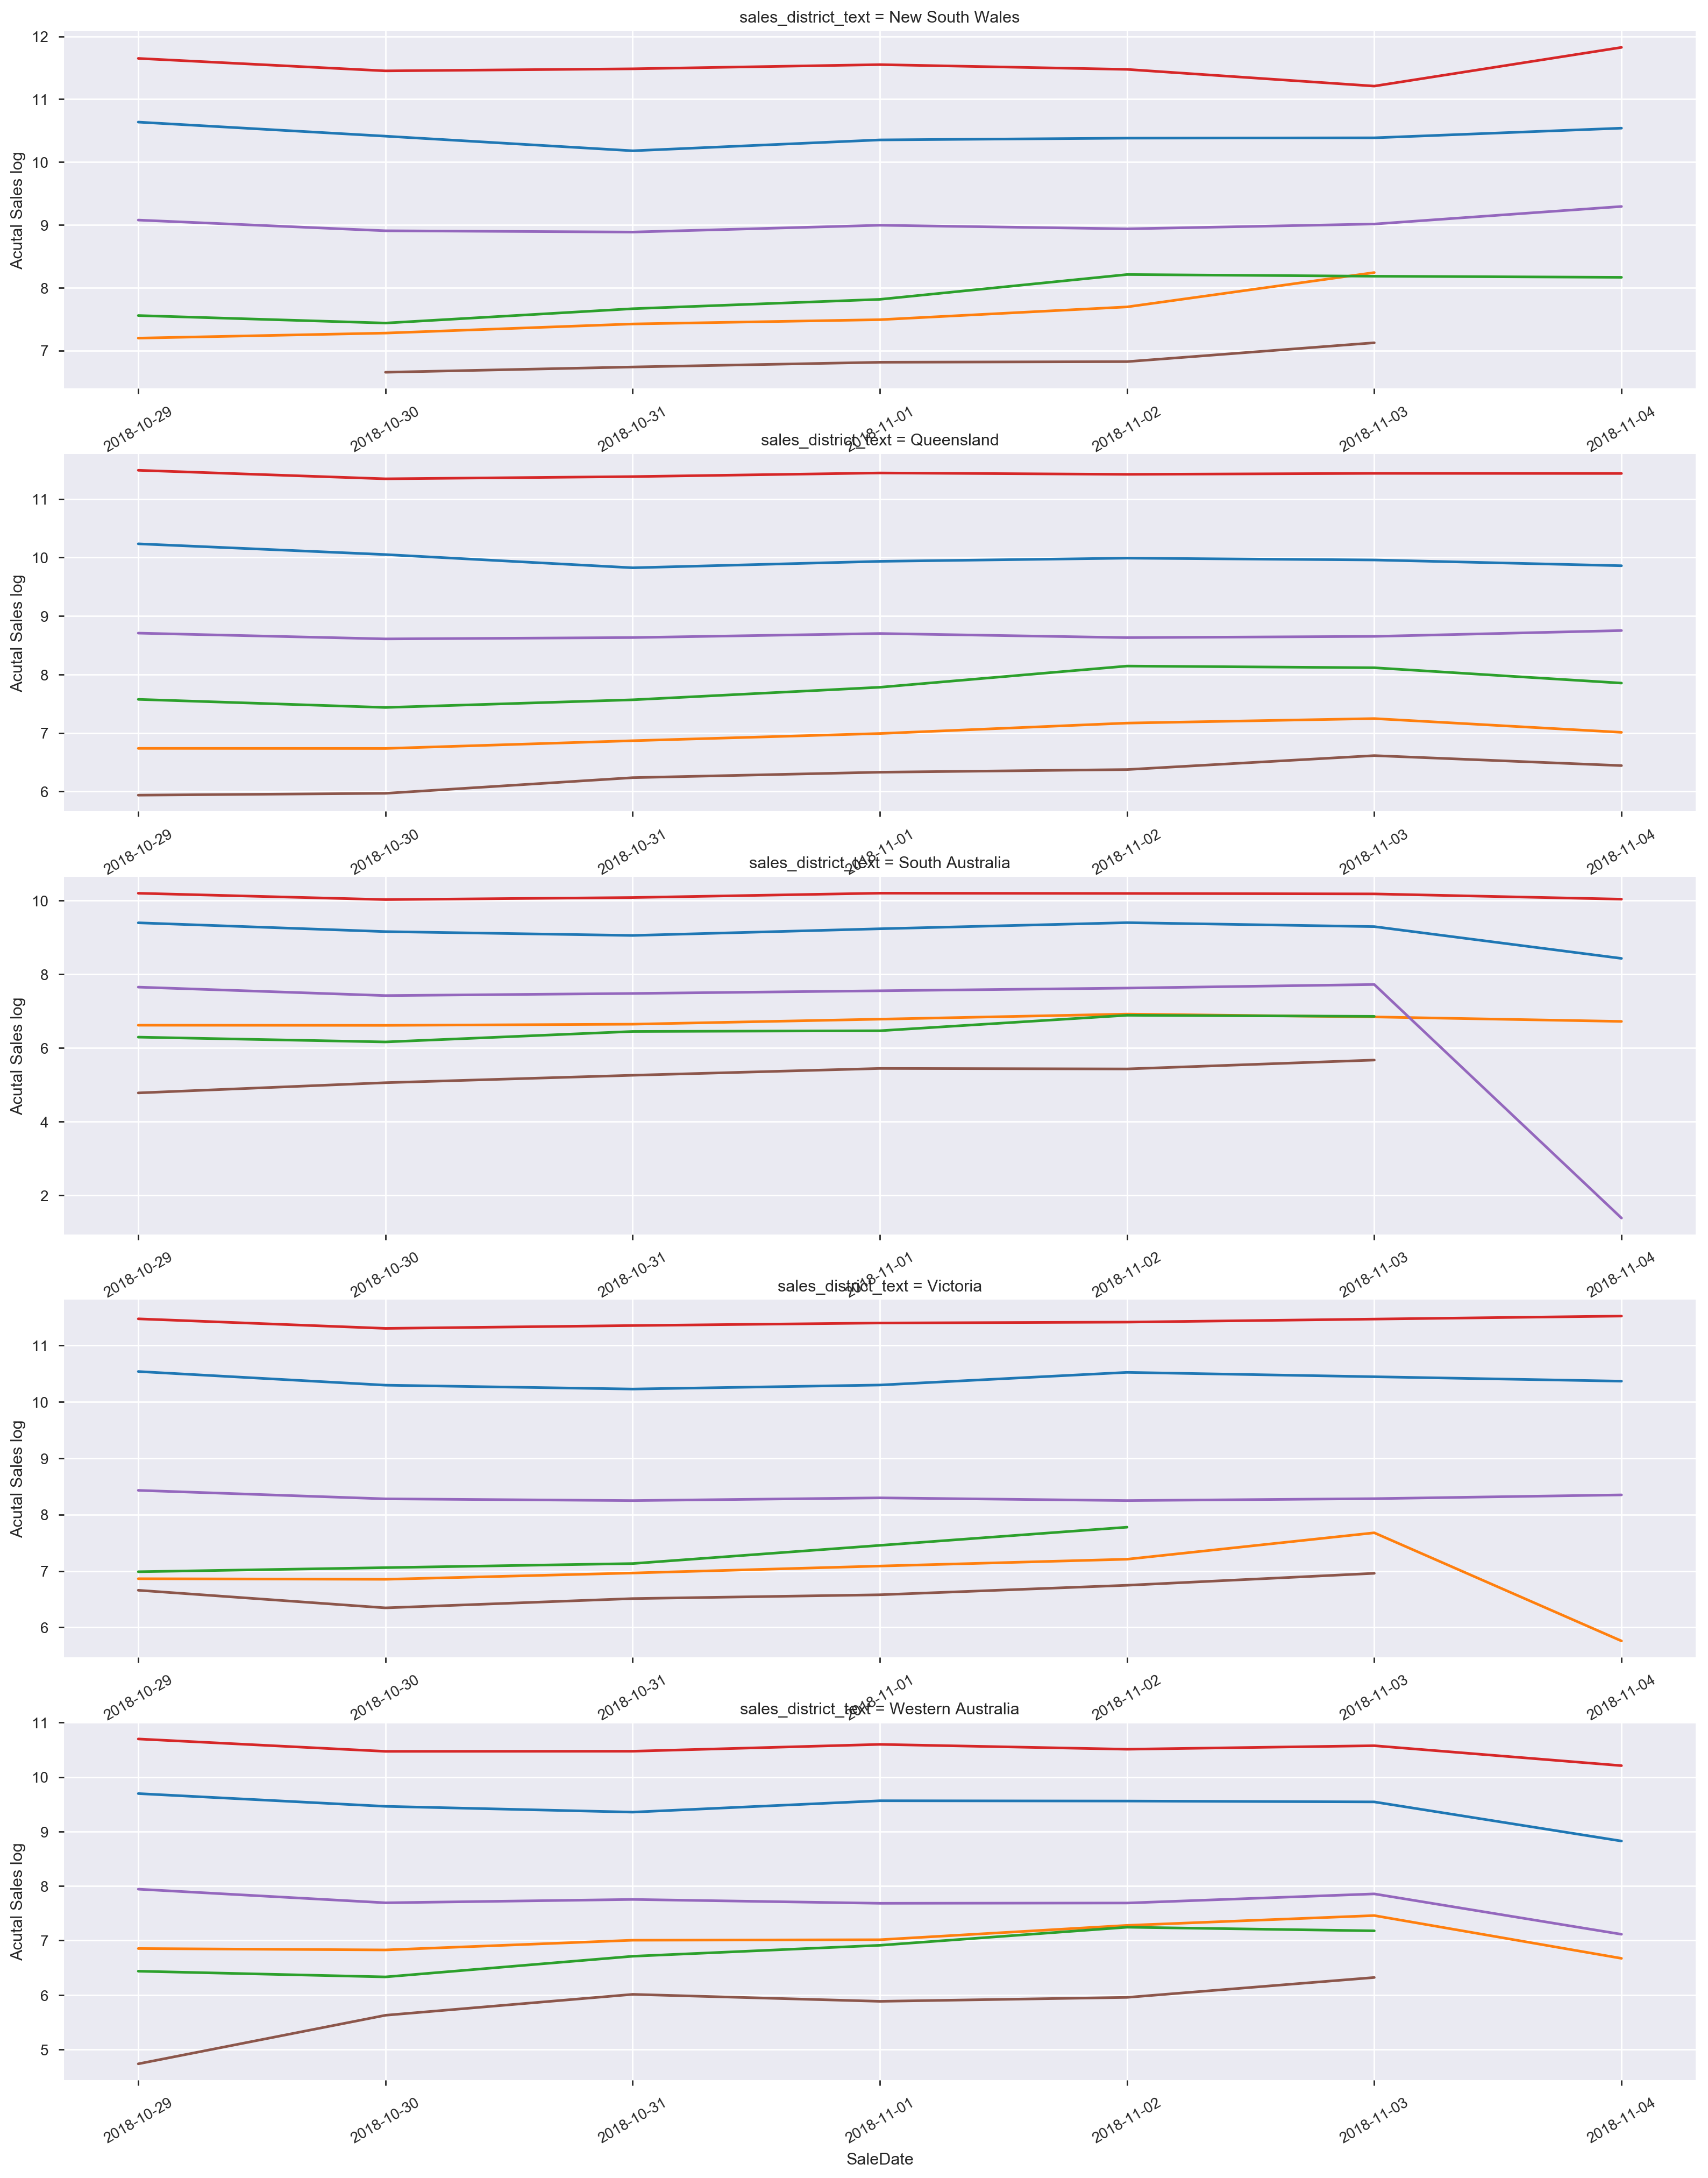

In [24]:
_ = data_df.groupby(['SaleDate', 'sales_district_text', 'ProductFamily'])['Acutal Sales'].sum().reset_index()
_['Acutal Sales log'] = np.log(_['Acutal Sales'])
g = sns.FacetGrid(data=_, row = "sales_district_text", hue='ProductFamily', 
                  sharey=False, sharex=False, height=4, aspect=4)
g.map(plt.plot, 'SaleDate', 'Acutal Sales log')
g.set_xticklabels(rotation=30)
plt.show()

### Sale by product

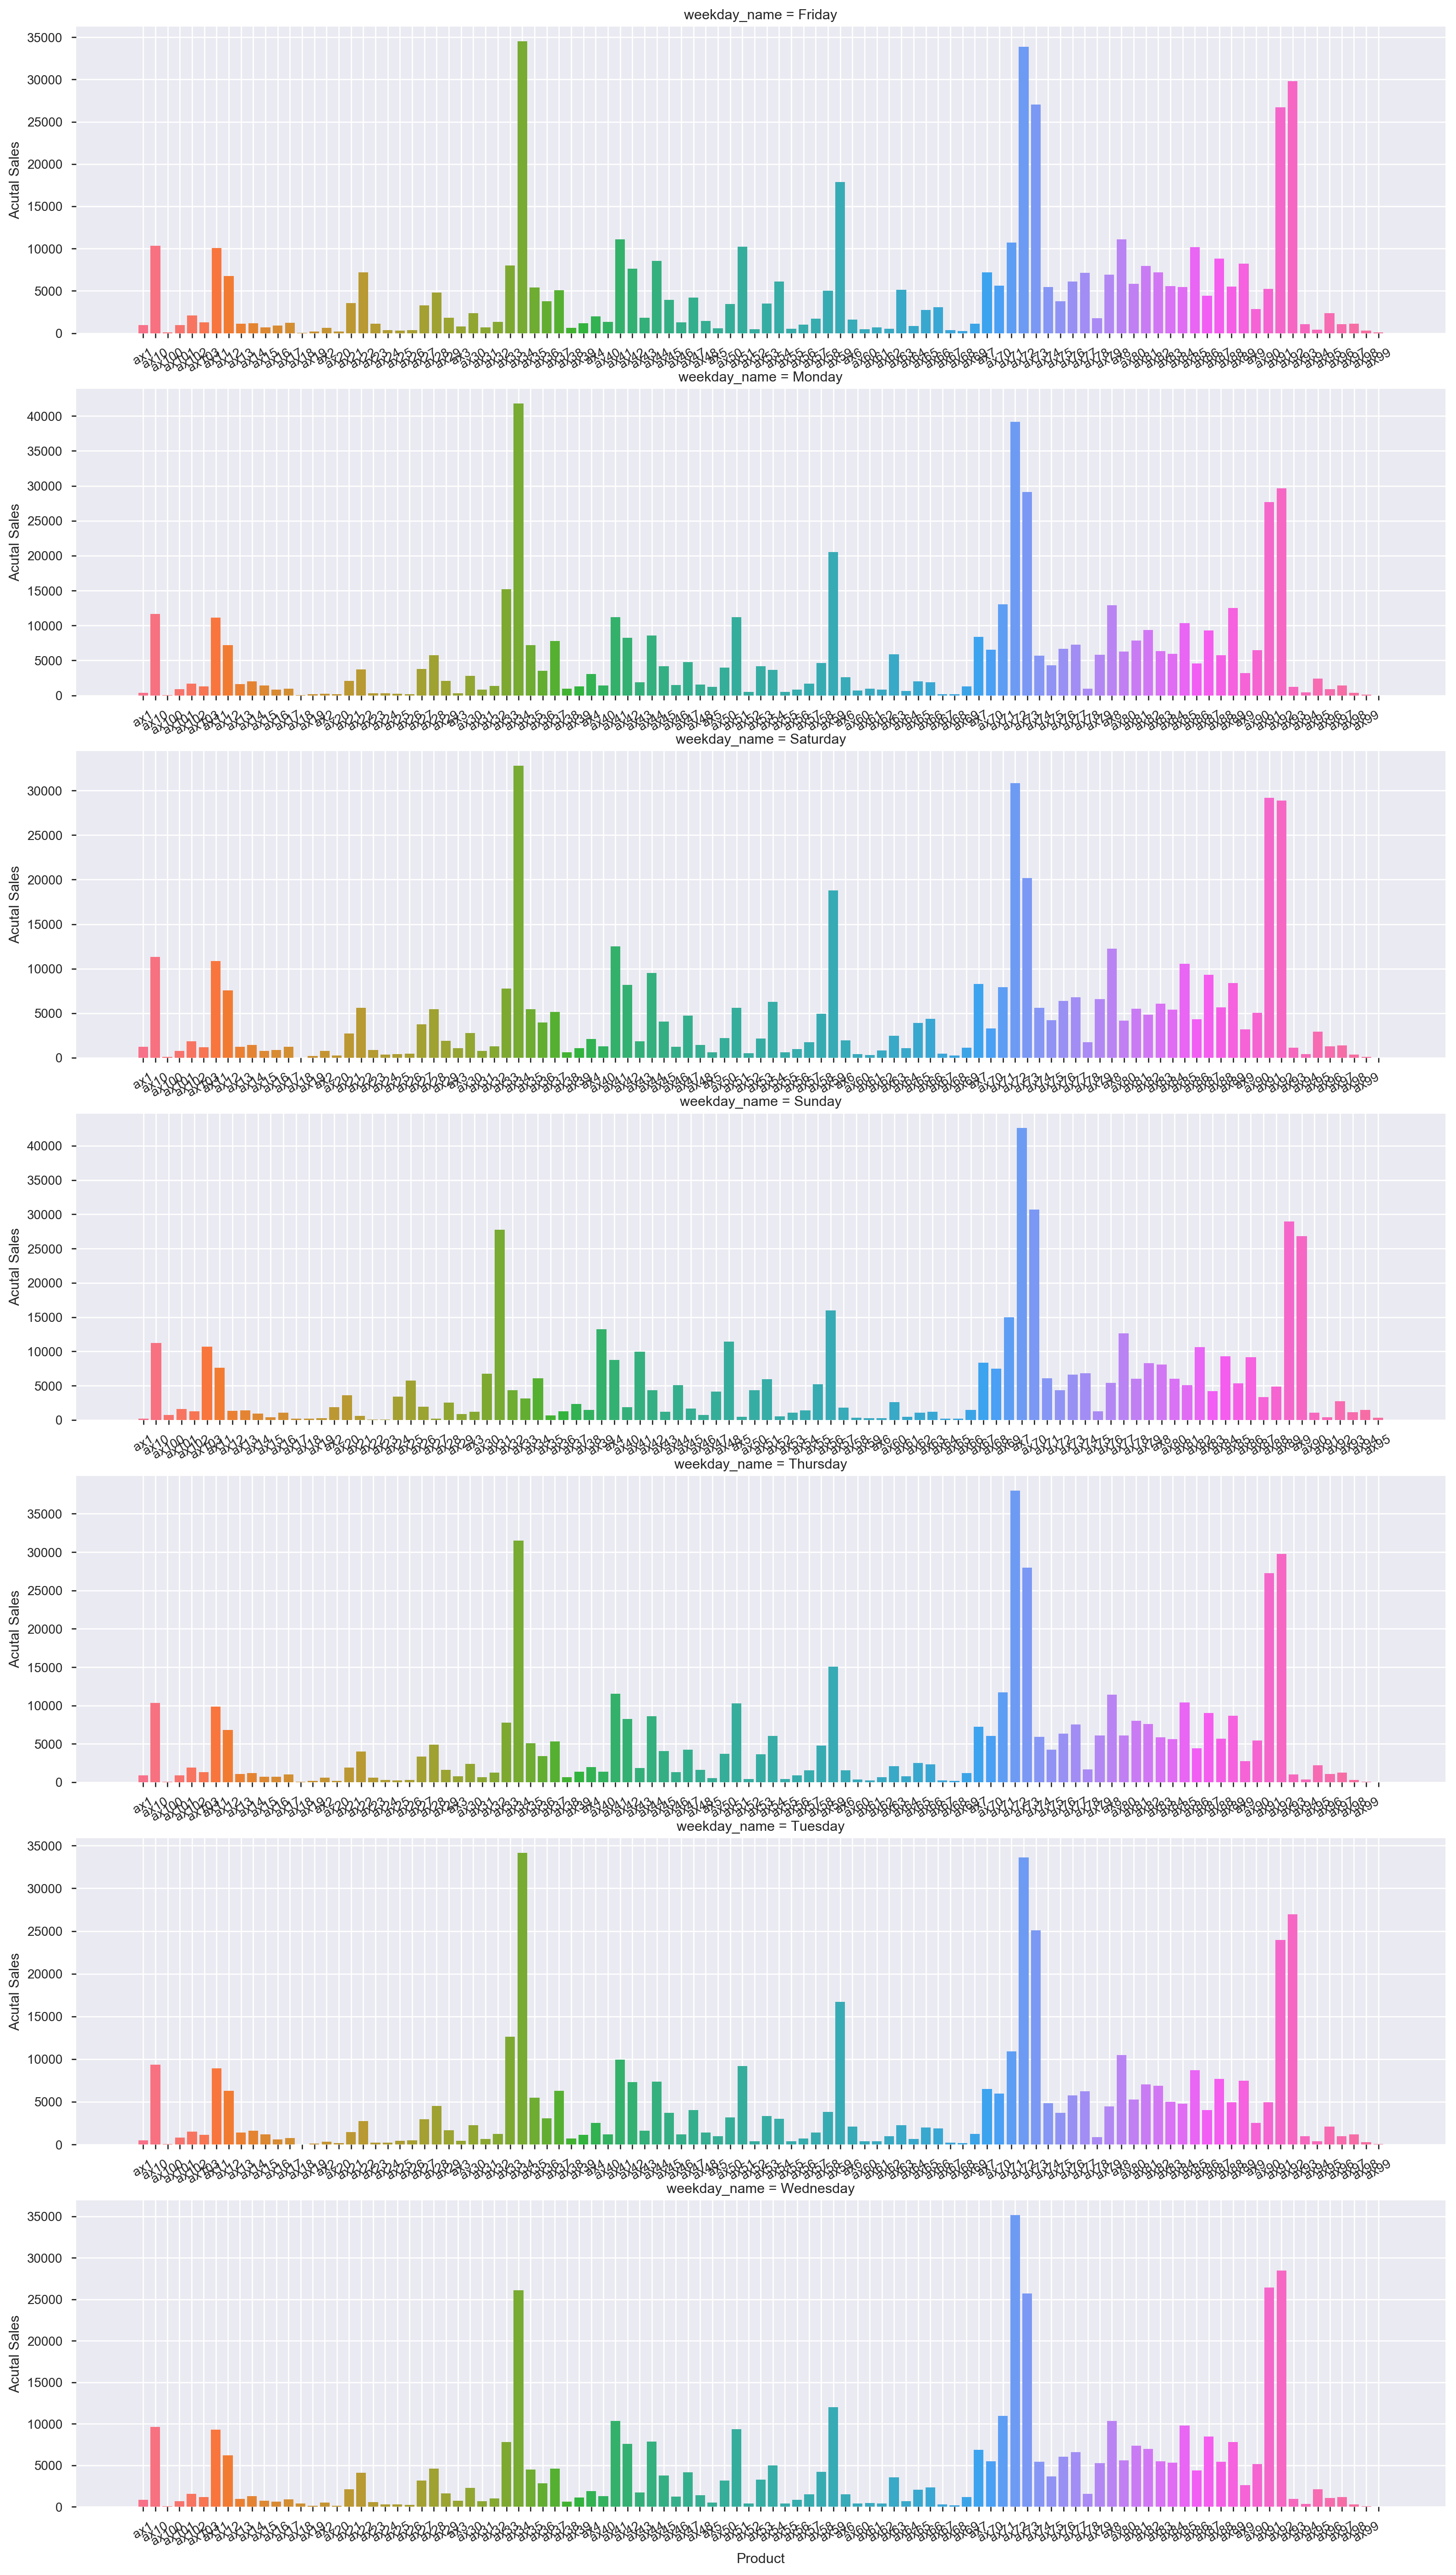

In [25]:
_ = data_df.groupby(['weekday_name', 'Product'])['Acutal Sales'].sum().reset_index()
_['Acutal Sales log'] = np.log(_['Acutal Sales'])
g = sns.FacetGrid(data=_, row = "weekday_name", hue='Product', 
                  sharey=False, sharex=False, height=4, aspect=4)
g.map(plt.bar, 'Product', 'Acutal Sales')
g.set_xticklabels(rotation=30)
plt.show()

# Data splitting

In [27]:
from sklearn.model_selection import train_test_split
X = data_df[categorial_features]
y = data_df['Acutal Sales'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data_df['Product'], test_size=0.2)

print('No of 1s in training {}'.format(len(X_train[y_train==1])))
print('No of 1s in testing {}'.format(len(X_test[y_test==1])))

#display(X_train.Product.value_counts(), X_test.Product.value_counts())
cat_features_indices=[X.columns.get_loc(c) for c in categorial_features]

No of 1s in training 85350
No of 1s in testing 21565


# No Lagging Approach

## Modelling

In [28]:
from catboost import CatBoostRegressor

model_appr1 = CatBoostRegressor(n_estimators=10000, depth=6,
    learning_rate=0.1,
    cat_features=cat_features_indices,   
  )

model_appr1.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True, silent=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
data_df['pred_sales_appr1'] = model_appr1.predict(X)

In [51]:
%%html
<img src="./model_1.png",width=60,height=60>

### Peformance using Predicted Sales column

In [32]:
rmse_given = root_mean_square_error(data_df['Acutal Sales'], data_df['Predicted Sales'])
smape_given = symmetric_mean_absolute_percentage_error(data_df['Acutal Sales'], data_df['Predicted Sales'])

print('RMSE of given prediction model {}'.format(rmse_given))
print('SMAPE of given prediction model {}'.format(smape_given))

RMSE of given prediction model 5.707047776920701
SMAPE of given prediction model 38.739983515878265


### Peformance using No Lagging

In [34]:
rmse_given = root_mean_square_error(data_df['Acutal Sales'], data_df['pred_sales_appr1'])
smape_given = symmetric_mean_absolute_percentage_error(data_df['Acutal Sales'], data_df['pred_sales_appr1'])

print('RMSE of given prediction model {}'.format(rmse_given))
print('SMAPE of given prediction model {}'.format(smape_given))

RMSE of given prediction model 7.00984917535346
SMAPE of given prediction model 43.10406668803032


# Lagging approach (using previous day sale)

### Data preperation

#### Adding the previous day sale as another feature. The previous sale per state, store, product family, product

In [35]:
data_copy_df = data_df.copy()

features = ['Acutal Sales', 'sales_district_text', 'Store', 'Product', 'ProductFamily', 'SaleDate']
prev_day_actual_sales = data_copy_df.sort_values(by='SaleDate')[features].groupby(['sales_district_text', 'Store', 'ProductFamily', 'Product'])['Acutal Sales'].shift(1)
prev_day_actual_sales = prev_day_actual_sales.rename('Acutal Sales PrevDay')

data_copy_df = pd.concat([data_copy_df, prev_day_actual_sales], axis=1)

data_copy_df.dropna(inplace=True,subset=['Acutal Sales PrevDay'])

In [36]:
data_copy_df.head()

,SaleDate,sales_district_text,Predicted Sales,Acutal Sales,Store,Product,ProductFamily,Predicted Sales Test (Using X Algorithm),dayofweek,weekday_name,month,pred_sales_appr1,Acutal Sales PrevDay
RecordID,,,,,,,,,,,,,
41,2018-10-30,New South Wales,11.0,4,st11,ax33,ClassA,NaN,1,Tuesday,10,6.091047,11.0
42,2018-10-30,New South Wales,20.0,16,st11,ax34,ClassA,NaN,1,Tuesday,10,13.195211,16.0
43,2018-10-30,New South Wales,1.0,1,st11,ax35,ClassA,NaN,1,Tuesday,10,4.480298,2.0
44,2018-10-30,New South Wales,8.0,2,st11,ax37,ClassA,NaN,1,Tuesday,10,4.554582,7.0
45,2018-10-30,New South Wales,5.0,3,st11,ax54,ClassA,NaN,1,Tuesday,10,4.425121,6.0


### Data splitting

In [37]:
features = categorial_features + ['Acutal Sales PrevDay']
X_appr2 = data_copy_df[features]
y_appr2 = data_copy_df['Acutal Sales'] 

X_train_appr2, X_test_appr2, y_train_appr2, y_test_appr2 = train_test_split(X_appr2, y_appr2, stratify=data_copy_df['Product'], test_size=0.2)

print('No of 1s in training {}'.format(len(X_train_appr2[y_train_appr2==1])))
print('No of 1s in testing {}'.format(len(X_test_appr2[y_test_appr2==1])))

#display(X_train.Product.value_counts(), X_test.Product.value_counts())
cat_features_indices =[X_appr2.columns.get_loc(c) for c in categorial_features]

No of 1s in training 66597
No of 1s in testing 16626


### Modelling

In [39]:
model_appr2 = CatBoostRegressor(n_estimators=10000, depth=6,
    learning_rate=0.1,
    cat_features=cat_features_indices,   
  )

model_appr2.fit(X_train_appr2, y_train_appr2, eval_set=(X_test_appr2, y_test_appr2), plot=True, silent=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
%%html
<img src="./model_2.png",width=60,height=60>

In [40]:
data_copy_df['pred_sales_appr2'] = model_appr2.predict(X_appr2)

### Performance using approach Lagging 

In [41]:
rmse_given = root_mean_square_error(data_copy_df['Acutal Sales'], data_copy_df['pred_sales_appr2'])
smape_given = symmetric_mean_absolute_percentage_error(data_copy_df['Acutal Sales'], data_copy_df['pred_sales_appr2'])

print('RMSE of approach 2 {}'.format(rmse_given))
print('SMAPE of approach 2 {}'.format(smape_given))

RMSE of approach 2 3.201038493261146
SMAPE of approach 2 34.01528025454284


### Performance using Predicted Sale columns

In [42]:
rmse_given = root_mean_square_error(data_copy_df['Acutal Sales'], data_copy_df['Predicted Sales'])
smape_given = symmetric_mean_absolute_percentage_error(data_copy_df['Acutal Sales'], data_copy_df['Predicted Sales'])

print('RMSE of given prediction model {}'.format(rmse_given))
print('SMAPE of given prediction model {}'.format(smape_given))

RMSE of given prediction model 5.58732466953606
SMAPE of given prediction model 39.45279151872712


In [43]:
data_copy_df.head()

,SaleDate,sales_district_text,Predicted Sales,Acutal Sales,Store,Product,ProductFamily,Predicted Sales Test (Using X Algorithm),dayofweek,weekday_name,month,pred_sales_appr1,Acutal Sales PrevDay,pred_sales_appr2
RecordID,,,,,,,,,,,,,,
41,2018-10-30,New South Wales,11.0,4,st11,ax33,ClassA,NaN,1,Tuesday,10,6.091047,11.0,5.173088
42,2018-10-30,New South Wales,20.0,16,st11,ax34,ClassA,NaN,1,Tuesday,10,13.195211,16.0,14.050039
43,2018-10-30,New South Wales,1.0,1,st11,ax35,ClassA,NaN,1,Tuesday,10,4.480298,2.0,3.194066
44,2018-10-30,New South Wales,8.0,2,st11,ax37,ClassA,NaN,1,Tuesday,10,4.554582,7.0,4.857492
45,2018-10-30,New South Wales,5.0,3,st11,ax54,ClassA,NaN,1,Tuesday,10,4.425121,6.0,3.112550


Text(0,0.5,'average sale')

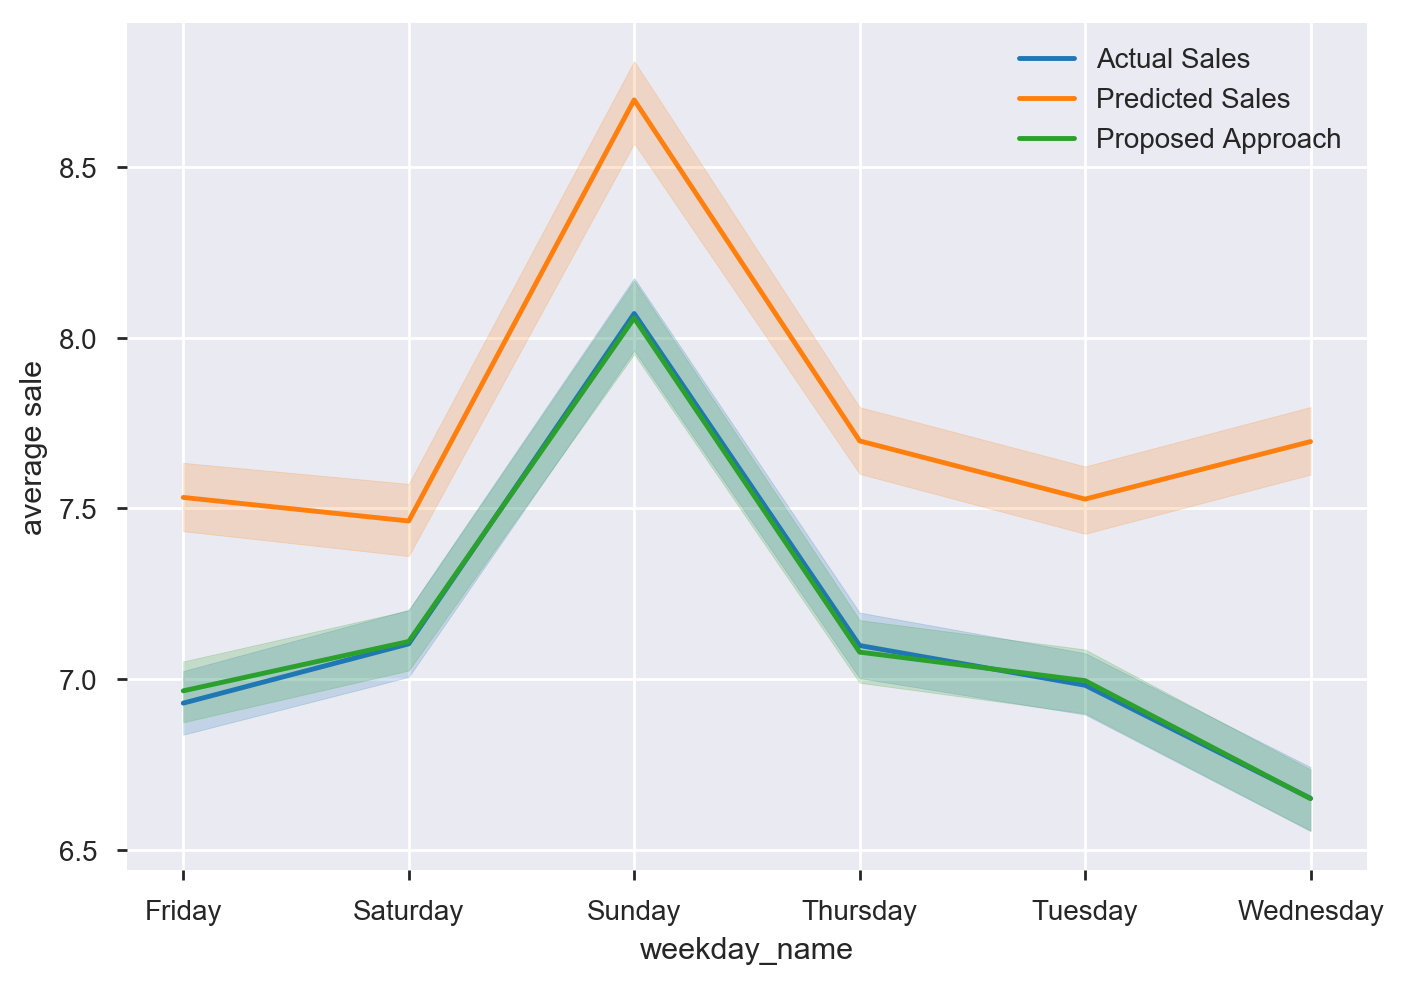

In [52]:
sns.lineplot(data=data_copy_df, y = 'Acutal Sales', x = 'weekday_name', label='Actual Sales', )
sns.lineplot(data=data_copy_df, y = 'Predicted Sales', x = 'weekday_name', label='Predicted Sales')
sns.lineplot(data=data_copy_df, y = 'pred_sales_appr2', x = 'weekday_name', label='Proposed Approach')
plt.ylabel('average sale')

## Analysing the feature importance of the features

The model has complex ctrs, so the SHAP values will be calculated approximately.


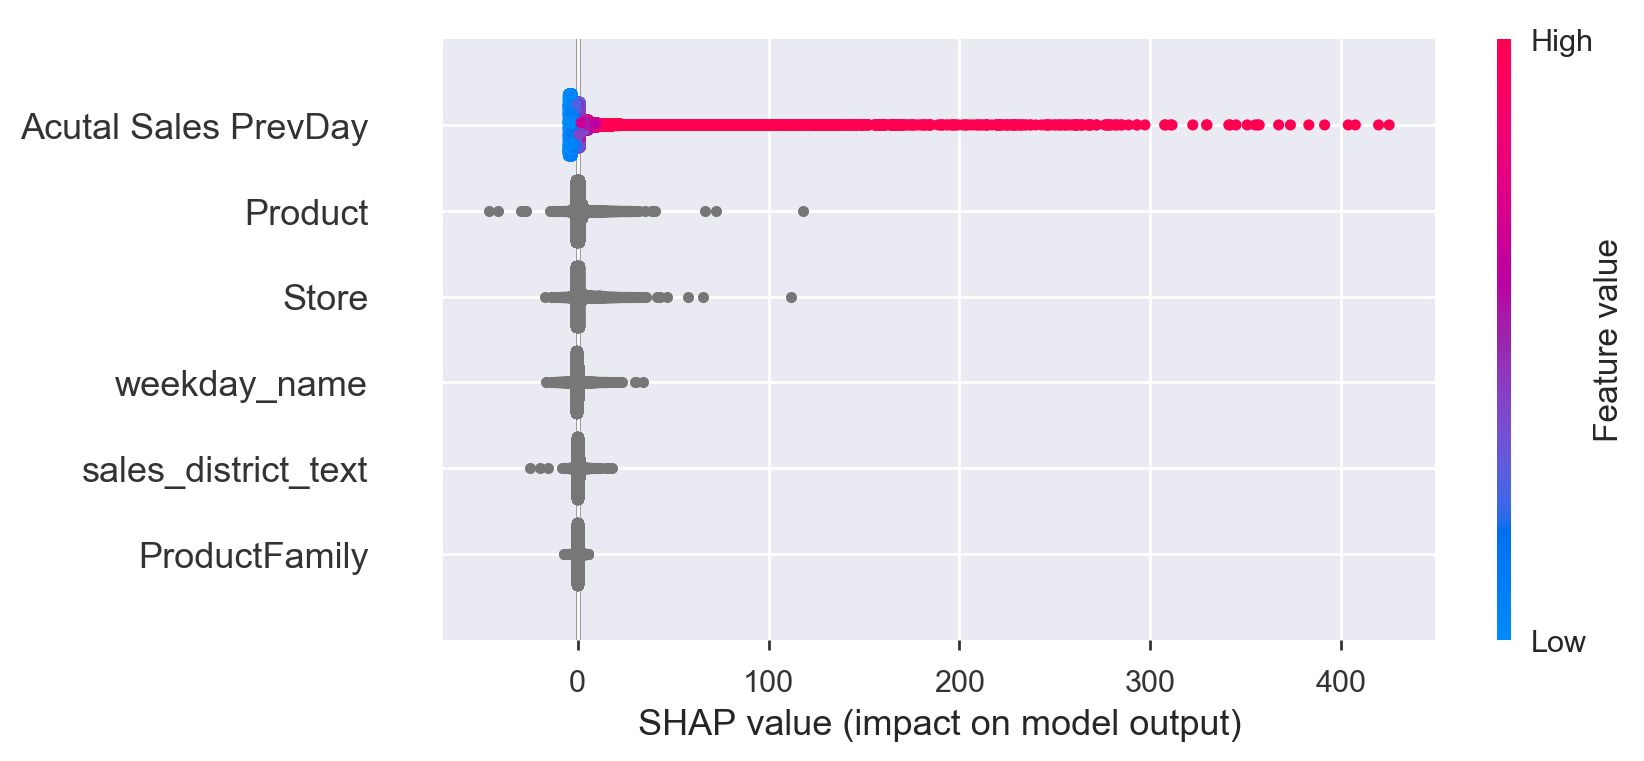

In [76]:
import shap
from catboost import Pool
shap_values = model_appr2.get_feature_importance(Pool(X_train_appr2, y_train_appr2, cat_features=cat_features_indices), fstr_type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_train_appr2)
